In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
PATH = "/content/drive/MyDrive/NorthFinal/"

# Подготовка данных для моделей первой группы

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
train = pd.read_csv(PATH + 'train.csv')
train = train.loc[train['БЕ'] == 5].drop(['БЕ', 'Дата транзакции'], axis = 1)

In [129]:
val = pd.read_excel(PATH + '1кв2021_1.xlsx', index_col = False)
val = val.loc[val['БЕ'] == 5].drop(['БЕ', 'Период', 'Расчет ликвидности - дата'], axis = 1)

In [119]:
val.head()

,Сумма в валюте транзакции
67,-6.501732e+07
68,-7.279720e+07
69,-2.388045e+07
70,-6.375853e+07
71,-6.619521e+07


In [127]:
train.tail()

,Сумма в RUB
165,-1.890154e+07
166,-6.657158e+07
167,-5.862773e+07
168,-1.243114e+07
169,-1.924510e+03


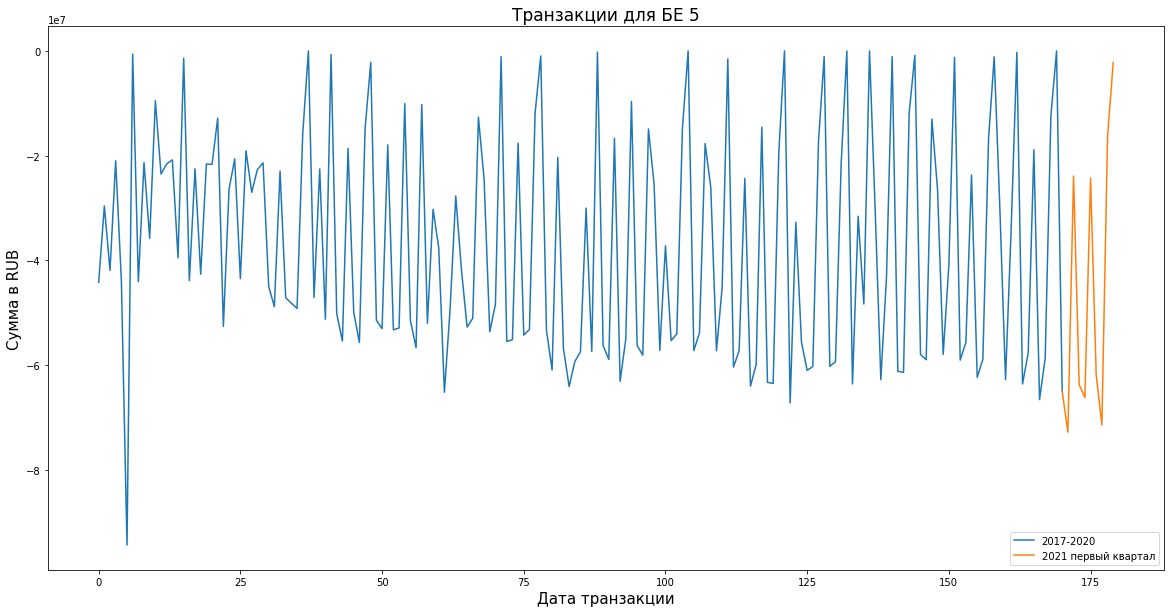

In [166]:
plt.figure(figsize=(20,10))
plt.plot(range(len(train) + 1), train.append({'Сумма в RUB':val['Сумма в валюте транзакции'][67]}, ignore_index=True), label='2017-2020')
plt.plot(range(len(train), len(train) + len(val)), val, label='2021 первый квартал')
plt.xlabel('Дата транзакции', fontsize=15)
plt.ylabel('Сумма в RUB', fontsize=15)
plt.title('Транзакции для БЕ 5', fontsize=17)
plt.legend()
plt.show()

# Скользящее среднее


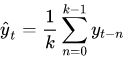

In [209]:
def plotMovingAverage(series, n):
    rolling_mean = series.rolling(window=n).mean()
    #доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

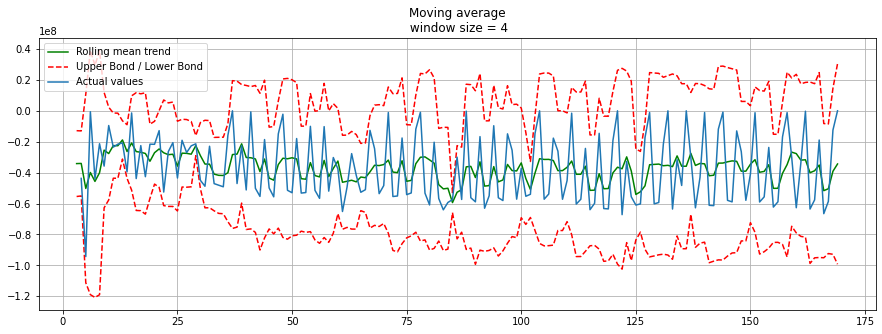

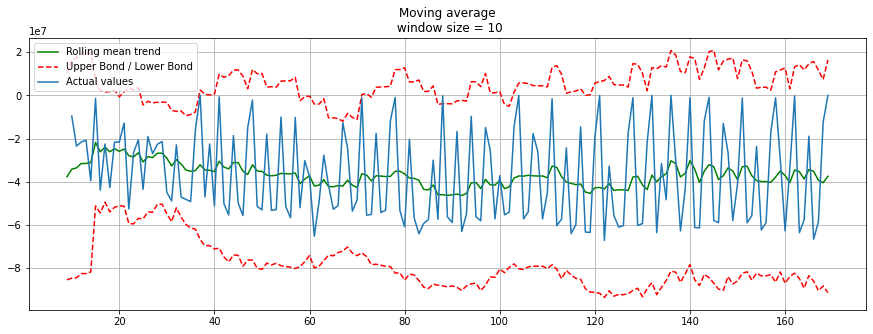

In [211]:
plotMovingAverage(dataset, 4)
plotMovingAverage(dataset, 10)

# Экспоненциальное сглаживание, модель Хольта-Винтерса


image.png

In [213]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

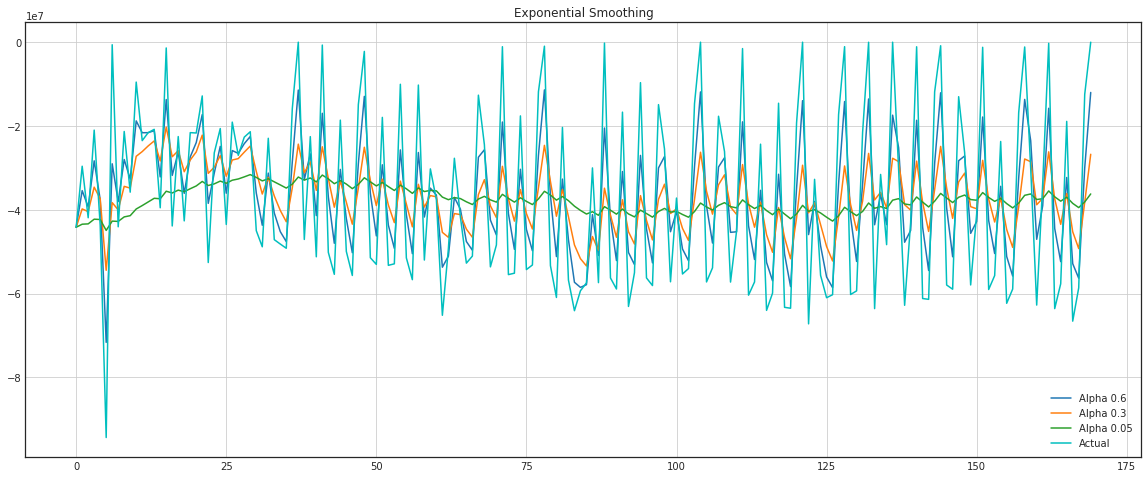

In [221]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.6, 0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset['Сумма в RUB'], alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset['Сумма в RUB'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

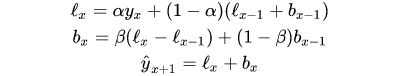

In [218]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

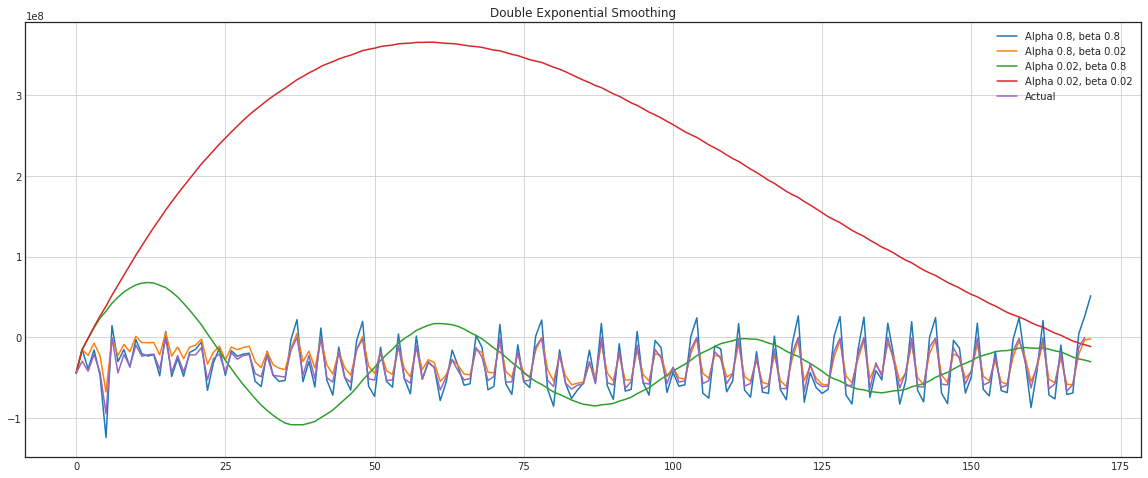

In [227]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.8, 0.02]:
        for beta in [0.8, 0.02]:
            plt.plot(double_exponential_smoothing(dataset['Сумма в RUB'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset['Сумма в RUB'].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [232]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    errors = []

    values = data.values
    alpha, beta, gamma = x

    tscv = TimeSeriesSplit(n_splits=3) 

    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 6, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [246]:
%%time
data = dataset['Сумма в RUB'][:-30] 

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


0.08858800010966755 0.09289276396341961 0.0846525935451185
CPU times: user 1.51 s, sys: 50.7 ms, total: 1.56 s
Wall time: 1.5 s


In [247]:
data = dataset['Сумма в RUB']
model = HoltWinters(data[:-10], slen = 20, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 10, scaling_factor = 2.56)
model.triple_exponential_smoothing()

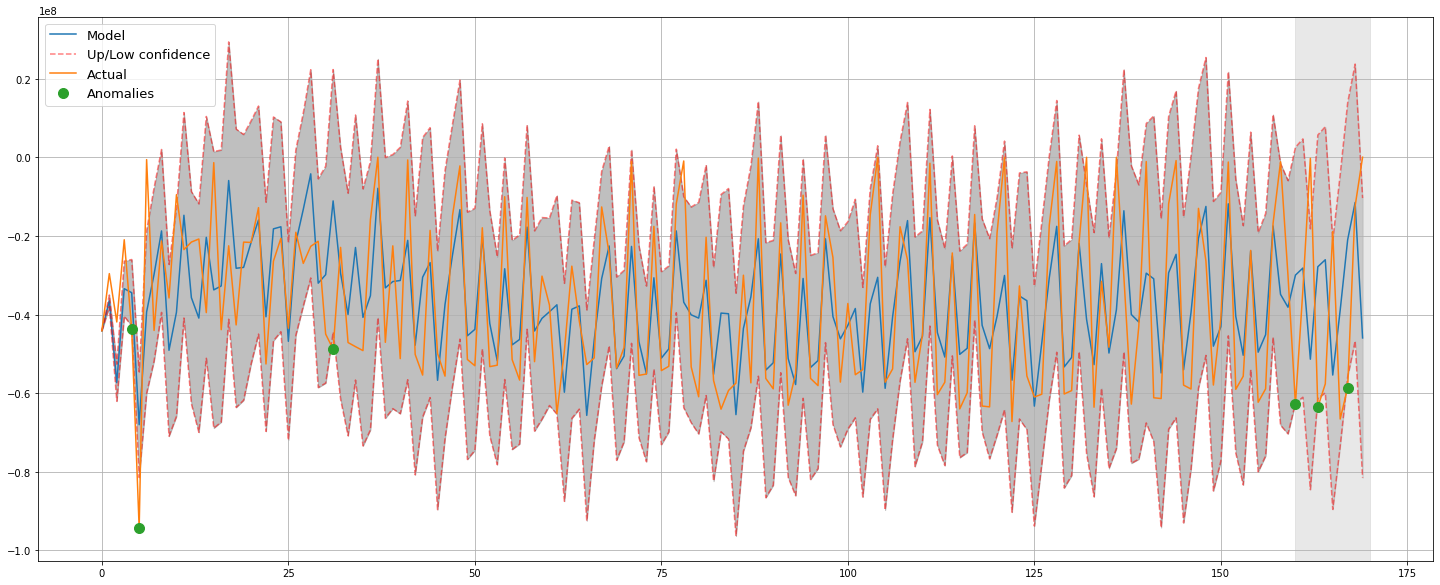

In [248]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-10, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()



# SARIMA

In [269]:
dataplus = dataset.copy() * -1

Критерий Дики-Фуллера: p=0.000000


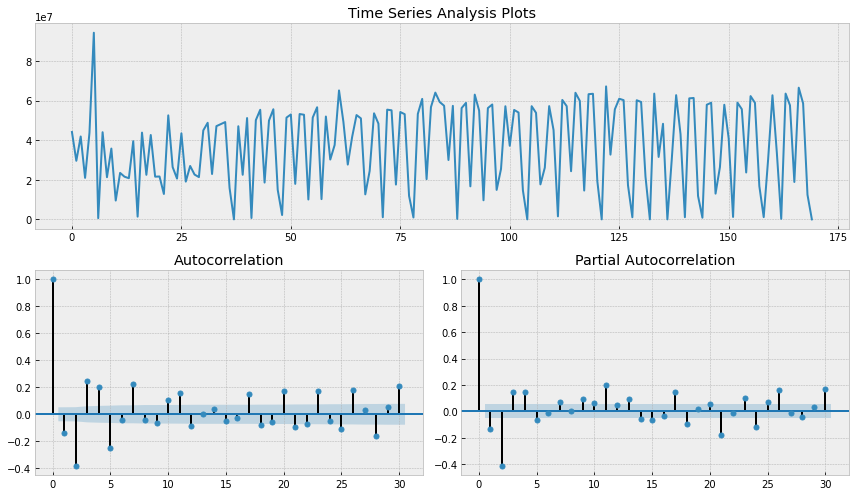

In [272]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataplus['Сумма в RUB'], lags=30)

Критерий Дики-Фуллера: p=0.000000
Оптимальный параметр преобразования Бокса-Кокса: 0.636743


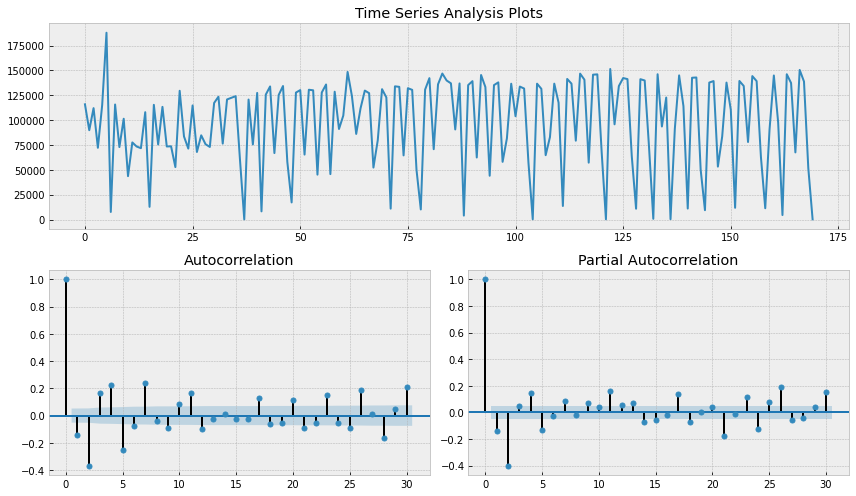

In [273]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataplus.copy()
data['Users_box'], lmbda = scs.boxcox(data['Сумма в RUB']+1)
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


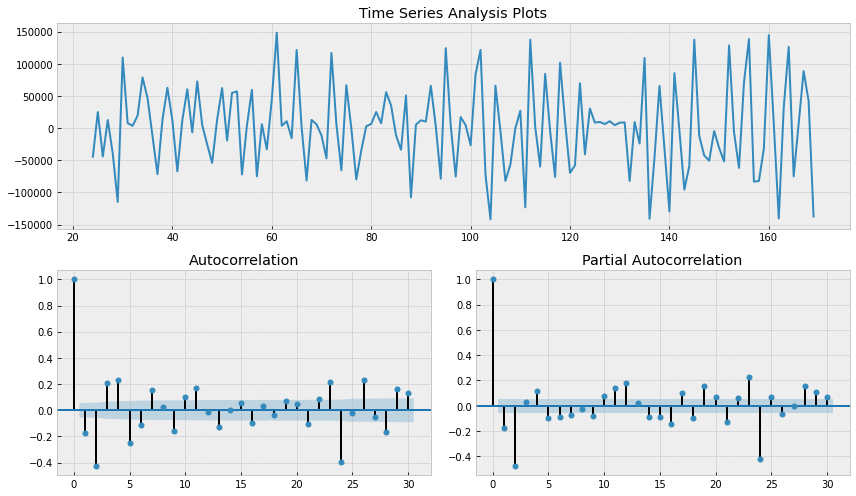

In [274]:
data['Users_box_season'] = data['Users_box'] - data['Users_box'].shift(24)
tsplot(data.Users_box_season[24:], lags=30)

Критерий Дики-Фуллера: p=0.000000


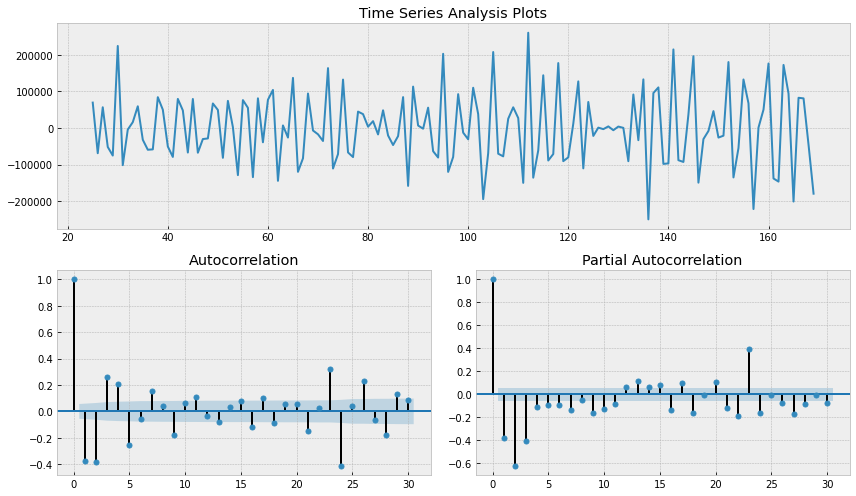

In [275]:
data['Users_box_season_diff'] = data['Users_box_season'] - data['Users_box_season'].shift(1)
tsplot(data.Users_box_season_diff[24+1:], lags=30)

In [280]:
ps = range(0, 10)
d=2
qs = range(0, 9)
Ps = range(0, 10)
D=2
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1800

In [281]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████| 1800/1800 [00:00<00:00, 105387.46it/s]

        parameters        aic
0     (0, 0, 0, 0)  30.994375
1206  (6, 6, 3, 0)  30.994375
1205  (6, 6, 2, 1)  30.994375
1204  (6, 6, 2, 0)  30.994375
1203  (6, 6, 1, 1)  30.994375
CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 31 ms


In [282]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary())     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



                                 Statespace Model Results                                 
Dep. Variable:                          Users_box   No. Observations:                  170
Model:             SARIMAX(4, 2, 3)x(4, 2, 1, 24)   Log Likelihood               -1531.981
Date:                            Sat, 19 Mar 2022   AIC                           3089.963
Time:                                    01:31:38   BIC                           3126.200
Sample:                                         0   HQIC                          3104.679
                                            - 170                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1706      6.645     -0.176      0.860     -14.194      11.853
ar.L2         -0.6223      1.350   

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Критерий Дики-Фуллера: p=0.000000


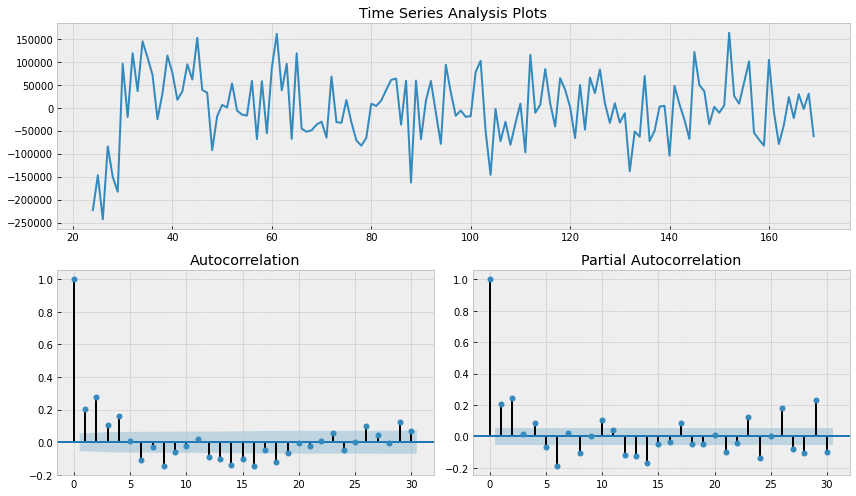

In [283]:
tsplot(best_model.resid[24:], lags=30)


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



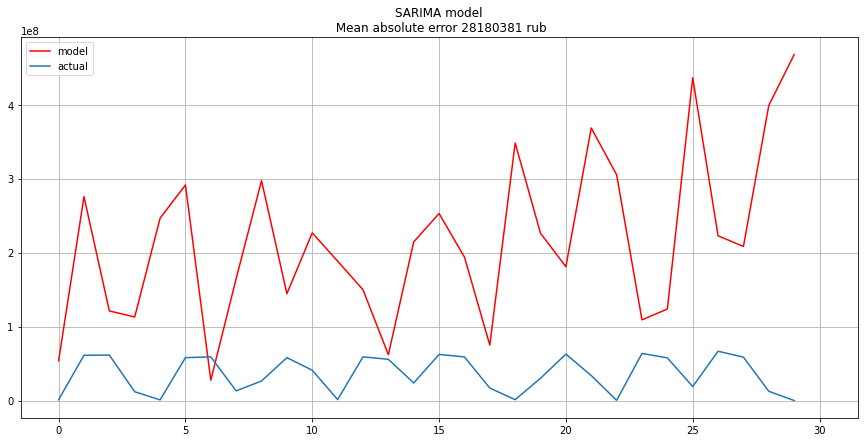

In [291]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-30:]
actual = data['Сумма в RUB'].values[-30:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} rub".format(round(mean_absolute_error(data.dropna()['Сумма в RUB'], data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)


# Подготовка данных для моделей второй группы

In [411]:
data = pd.read_csv(PATH + 'train.csv')

In [412]:
new_df = data['Дата транзакции'].str.split('-',expand=True)
data = pd.concat([data,new_df], axis = 1)
data.rename(columns={0: 'year', 1: 'month', 2: 'day'}, inplace=True)

In [413]:
def quantityPerCategory(col):
  new_col = [1]
  j = 2
  for i in range(1, len(list(data[col]))):
    if data[col][i] == data[col][i - 1]:
      new_col.append(j)
      j += 1
    else:
      new_col.append(1)
      j = 2
  return new_col

In [414]:
data = pd.concat([data, pd.Series(quantityPerCategory('day'))], axis = 1)
data.rename(columns={0: 'quantityPerDay'}, inplace = True)
data = pd.concat([data, pd.Series(quantityPerCategory('month'))], axis = 1)
data.rename(columns={0: 'quantityPerMonth'}, inplace = True)
data = pd.concat([data, pd.Series(quantityPerCategory('year'))], axis = 1)
data.rename(columns={0: 'quantityPerYear'}, inplace = True)
new_col = []
for i in range(len(list(data['month']))):
  if data['month'][i] in ['01', '02', '03']:
    new_col.append(1)
  if data['month'][i] in ['04', '05', '06']:
    new_col.append(2)
  if data['month'][i] in ['07', '08', '09']:
    new_col.append(3)
  if data['month'][i] in ['10', '11', '12']:
    new_col.append(4)
data = pd.concat([data, pd.Series(new_col)], axis = 1)
data.rename(columns={0: 'Quarter'}, inplace = True)

In [418]:
data.head(15)

,БЕ,Дата транзакции,Сумма в RUB,year,month,day,quantityPerDay,quantityPerMonth,quantityPerYear,Quarter
0,5,2017-01-11,-4.416300e+07,2017,01,11,1,1,1,1
1,5,2017-01-18,-2.960046e+07,2017,01,18,1,2,2,1
2,5,2017-01-25,-4.189707e+07,2017,01,25,1,3,3,1
3,5,2017-02-08,-2.098554e+07,2017,02,08,1,1,4,1
4,5,2017-02-15,-4.373594e+07,2017,02,15,1,2,5,1
5,5,2017-02-22,-9.434364e+07,2017,02,22,1,3,6,1
6,5,2017-03-01,-6.101577e+05,2017,03,01,1,1,7,1
7,5,2017-03-09,-4.405284e+07,2017,03,09,1,2,8,1
8,5,2017-03-15,-2.131114e+07,2017,03,15,1,3,9,1
9,5,2017-03-22,-3.578870e+07,2017,03,22,1,4,10,1


In [419]:
data = pd.get_dummies(data, columns = ['year', 'month', 'quantityPerMonth', 'Quarter'])

In [421]:
data.head()

,БЕ,Дата транзакции,Сумма в RUB,day,quantityPerDay,quantityPerYear,year_2017,year_2018,year_2019,year_2020,...,quantityPerMonth_7,quantityPerMonth_8,quantityPerMonth_9,quantityPerMonth_10,quantityPerMonth_11,quantityPerMonth_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,5,2017-01-11,-4.416300e+07,11,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5,2017-01-18,-2.960046e+07,18,1,2,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5,2017-01-25,-4.189707e+07,25,1,3,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,5,2017-02-08,-2.098554e+07,08,1,4,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,2017-02-15,-4.373594e+07,15,1,5,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Линейные модели

LAMA


In [ ]:
!pip install autowoe

In [423]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np

import os
import requests
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from autowoe import AutoWoE, ReportDeco

In [426]:
auto_woe_0 = AutoWoE(interpreted_model=True,
                     monotonic=False,
                     max_bin_count=5,
                     select_type=None,
                     pearson_th=0.9,
                     auc_th=.505,
                     vif_th=10.,
                     imp_th=0,
                     th_const=32,
                     force_single_split=True,
                     th_nan=0.01,
                     th_cat=0.005,
                     auc_tol=1e-4,
                     cat_alpha=100,
                     cat_merge_to="to_woe_0",
                     nan_merge_to="to_woe_0",
                     imp_type="feature_imp",
                     regularized_refit=False,
                     p_val=0.05,
                     verbose=2
        )

auto_woe_0 = ReportDeco(auto_woe_0, )

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

In [425]:
train, test = train_test_split(data, test_size=0.2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

automl = TabularAutoML(
    task = Task(
        name = 'regression',
        metric = lambda y_true, y_pred: mean_absolute_error(y_true, (y_pred > 0.5)*1))
)
oof_pred = automl.fit_predict(
    df_train,
    roles = {'target': 'Сумма в RUB', 'drop': ['Сумма в RUB']}
)
test_pred = automl.predict(df_test)

pd.DataFrame({
    'PassengerId':df_test.PassengerId,
    'Survived': (test_pred.data[:, 0] > 0.5)*1
}).to_csv('submit.csv', index = False)

In [427]:
auto_woe_0.fit(train,
               target_name="Сумма в RUB",
              )

ValueError: ignored

In [ ]:
automl = TabularAutoML(
    task = Task(
        name = 'regression',
        metric = lambda y_true, y_pred: f1_score(y_true, (y_pred > 0.5)*1))
)